Exercise 24

4.1 1D Harmonic oscillator
Demonstrating that a molecular dynamics apprach with a terhmostat results in the same thermal ensemble of position observations as did the Metropolis MC approach.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import builtins

# Constants
m = 1
omega = 1 
k = m * omega ** 2  # spring constant
kT_values = [0.05, 0.15, 0.25, 0.35]  # Different values for kT

x_min = -3
x_max = 3
x_points = 400

bin_number = 50

# Potential energy function based on harmonic potential
def V(x, k, x0):
    return 0.5 * k * (x - x0) ** 2

# Metropolis sampling function
def metropolis_sampling(x0, N, Delta, kT):
    samples = []
    current_x = x0
    for _ in builtins.range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Acceptance probability (min(1, P(x') / P(x)))
        acceptance_prob = min(1, np.exp(-(V(proposed_x, k, x0) - V(current_x, k, x0)) / kT))

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x  # Accept the move

        # Store the current position
        samples.append(current_x)

    return np.array(samples)

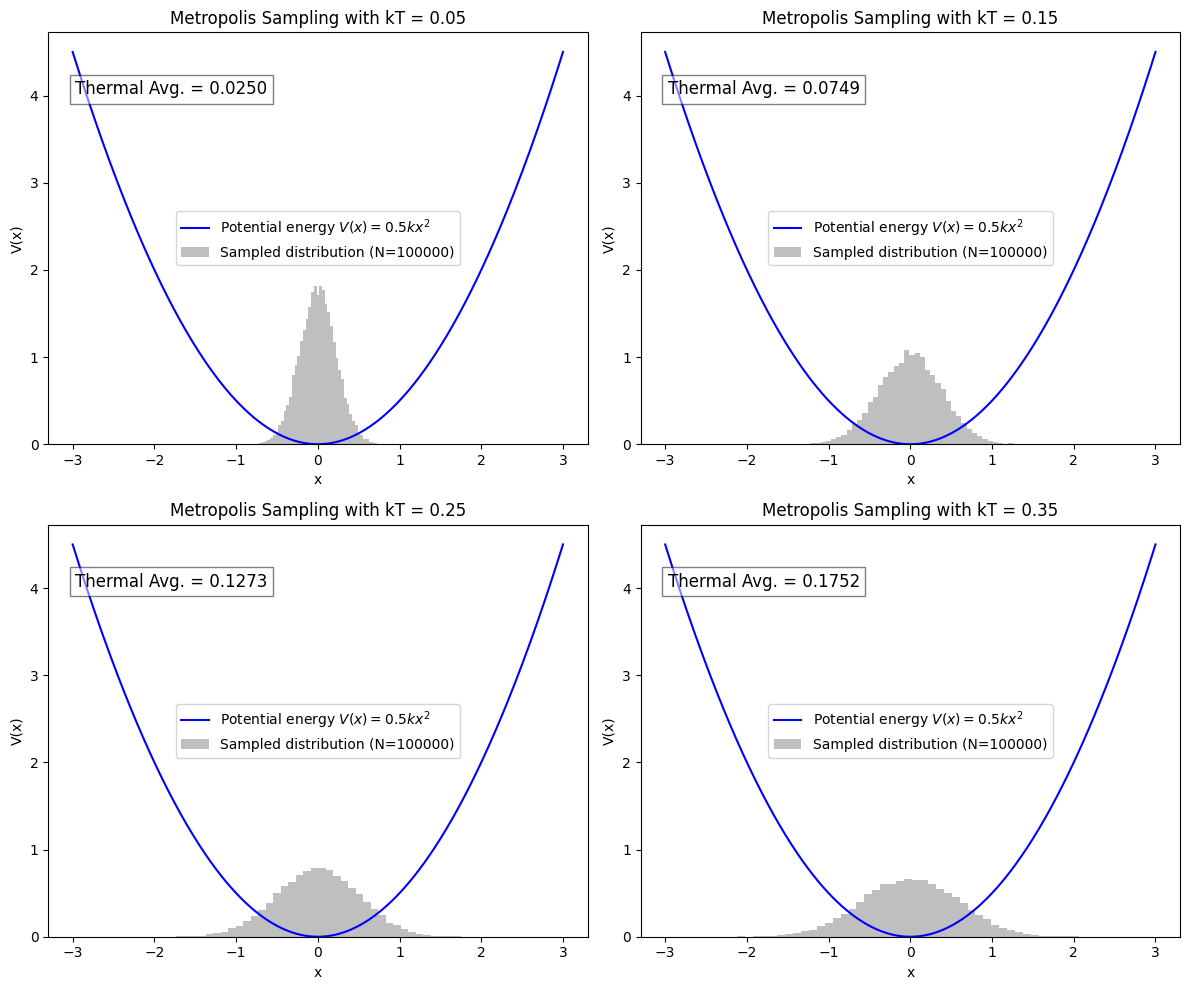

In [25]:
# Initial position and parameters for sampling
x0 = 0.0
N = 100000
Delta = 1

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) 
axs = axs.flatten() 

for i, kT in enumerate(kT_values):
    xs = np.linspace(x_min, x_max, x_points)
    samples = metropolis_sampling(x0, N, Delta, kT)
    
    potential_energies = V(samples, k, x0)
    
    thermal_average = np.mean(potential_energies)
    
    axs[i].plot(xs, V(xs, k, x0), label="Potential energy $V(x) = 0.5kx^2$", color="blue")
    
    axs[i].hist(samples, bins=bin_number, density=True, alpha=0.5, color='gray', label=f"Sampled distribution (N={N})")
    
    axs[i].text(0.05, 0.85, f'Thermal Avg. = {thermal_average:.4f}', transform=axs[i].transAxes,
                fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('V(x)')
    axs[i].set_title(f'Metropolis Sampling with kT = {kT}')
    axs[i].legend()

plt.tight_layout()
plt.show()

4.3 Constant energy MD
Implement velocity Verlet algo. Delta_t=0.01 plot positions as fct of t. Also, Plot distribution of positions observed at regular time intervals.

C:\Users\jacob\AppData\Local\Temp\ipykernel_8304\3480852628.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


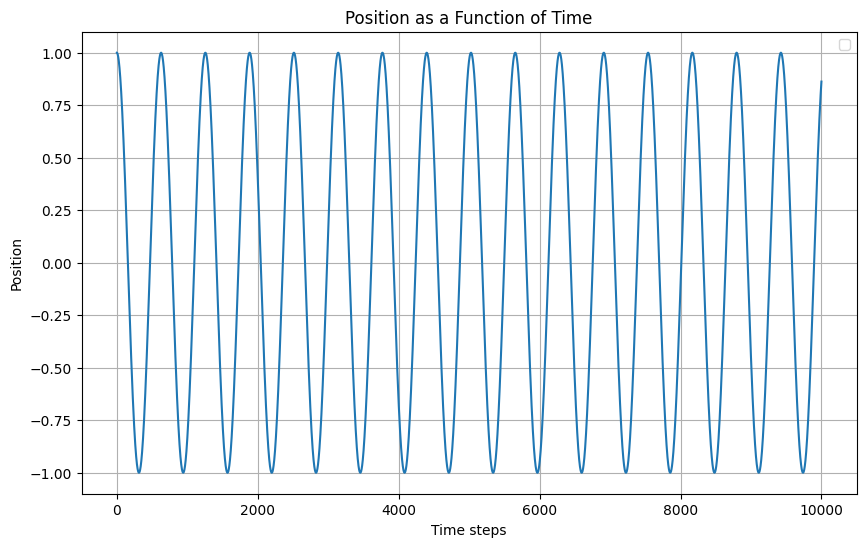

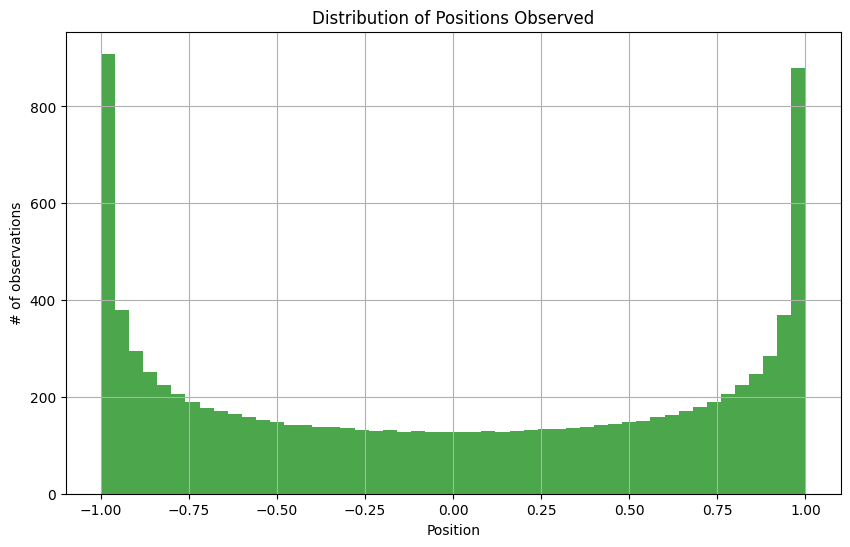

In [67]:
# Constants
Delta_t = 0.01  # time step
time_steps = 10000  # total number of time steps

# Harmonic potential function
def V(x, k):
    return 0.5 * k * x ** 2

# Force as the derivative of the potential: F = -dV/dx = -k * x
def force(x, k):
    return -k * x

def velocity_verlet(x0, v0, k, m, Delta_t, time_steps, adjustment_interval = 0, sigma = 0):
    positions = []
    velocities = []
    times = np.arange(0, time_steps * Delta_t, Delta_t)  # time array
    x = x0
    v = v0
    a = force(x, k) / m  # initial acceleration

    for t in times:
        # Update position
        x = x + v * Delta_t + 0.5 * a * Delta_t ** 2
        positions.append(x)

        # Calculate new acceleration
        a_new = force(x, k) / m

        # Update velocity
        v = v + 0.5 * (a + a_new) * Delta_t
        velocities.append(v)

        # Update acceleration for next step
        a = a_new

        if (sigma!=0):
            # Adjust velocities every `adjustment_interval` steps
            if (step + 1) % adjustment_interval == 0:
                v = np.random.normal(0, sigma)  # Draw a new velocity from N(0, sigma^2)

    return np.array(positions), np.array(velocities), times / Delta_t

x0 = 1.0  # initial x
v0 = 0.0  # initial v

# Run simulation
positions, velocities, times = velocity_verlet(x0, v0, k, m, Delta_t, time_steps)

# Plot 1: Position as a function of time steps
plt.figure(figsize=(10, 6))
plt.plot(times, positions)
plt.xlabel('Time steps')
plt.ylabel('Position')
plt.title('Position as a Function of Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Distribution of positions observed at regular intervals
plt.figure(figsize=(10, 6))
plt.hist(positions, bins=50, alpha=0.7, color='g')
plt.xlabel('Position')
plt.ylabel('# of observations')
plt.title('Distribution of Positions Observed')
plt.grid(True)
plt.show()


4.4 Constant temperature MD
Implement NVT thermostat, i.e. draw random velocity from $$N(0,sigma^2)$$, sigma=\sqrt(kT/m)

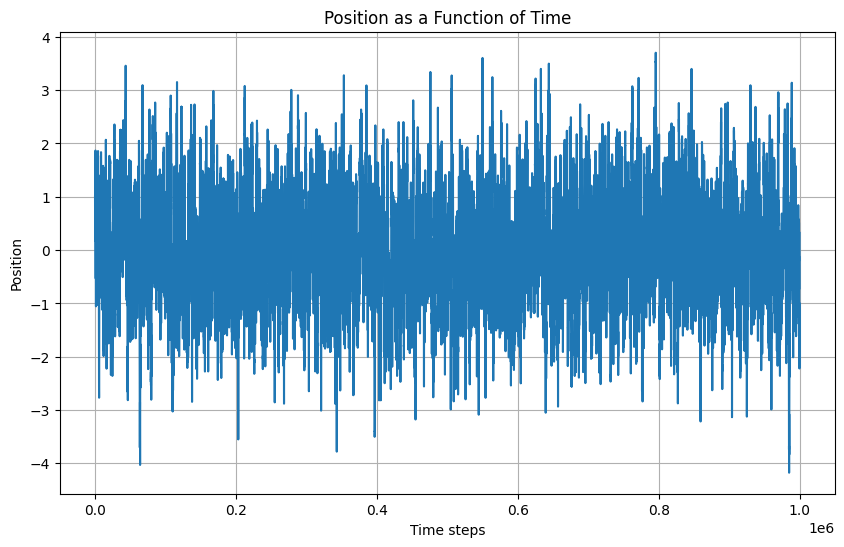

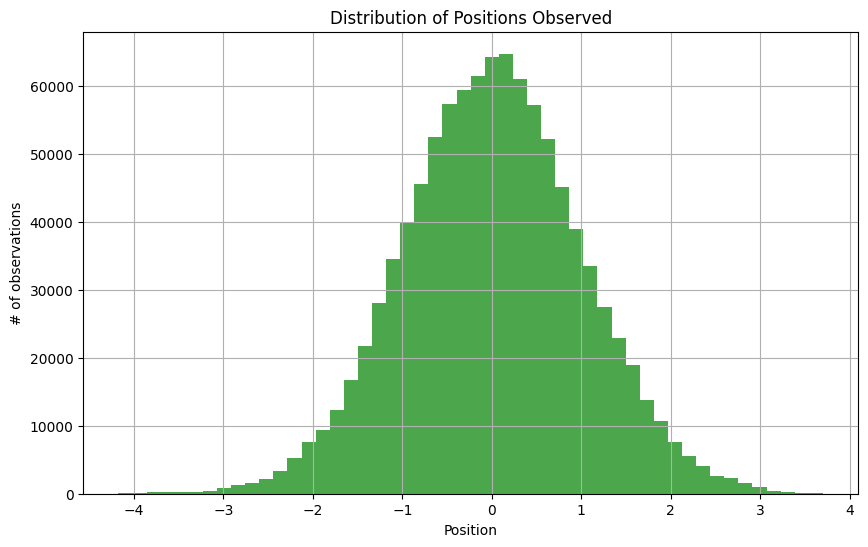

In [70]:
# Constants
Delta_t = 0.01  # time step
time_steps = 1000000  # total number of time steps

# Harmonic potential function
def V(x, k):
    return 0.5 * k * x ** 2

def force(x, k):
    return -k * x

def velocity_verlet(x0, v0, k, m, Delta_t, time_steps, adjustment_interval=0, sigma=0):
    positions = []
    velocities = []
    potential_energies = []
    thermostat_actions = []  
    times = np.arange(0, time_steps * Delta_t, Delta_t)
    x = x0
    v = v0
    a = force(x, k) / m 

    for step in range(time_steps):
        x = x + v * Delta_t + 0.5 * a * Delta_t ** 2
        positions.append(x)

        a_new = force(x, k) / m

        v = v + 0.5 * (a + a_new) * Delta_t
        velocities.append(v)

        a = a_new

        potential_energies.append(V(x, k))

        if sigma != 0 and (step + 1) % adjustment_interval == 0:
            v = np.random.normal(0, sigma)
            thermostat_actions.append(step + 1)

    return np.array(positions), np.array(velocities), np.array(potential_energies), np.array(thermostat_actions), np.arange(time_steps)

x0 = 1.0
v0 = 0.0
k = 1.0
m = 1.0
sigma = 1.0
adjustment_interval = 50

# Run simulation with thermostat
positions, velocities, potential_energies, thermostat_actions, times = velocity_verlet(
    x0, v0, k, m, Delta_t, time_steps, adjustment_interval, sigma
)

# Plot 1: Position as a function of time steps
plt.figure(figsize=(10, 6))
plt.plot(times, positions)
plt.xlabel('Time steps')
plt.ylabel('Position')
plt.title('Position as a Function of Time')
plt.grid(True)
plt.show()

# Plot 2: Distribution of positions observed at regular intervals
plt.figure(figsize=(10, 6))
plt.hist(positions, bins=50, alpha=0.7, color='g')
plt.xlabel('Position')
plt.ylabel('# of observations')
plt.title('Distribution of Positions Observed')
plt.grid(True)
plt.show()


Exercise 25: 5.1 1D Double well demonstating that thermal samples can be established.

5.2 The potential
A potential is given. Plot it. 

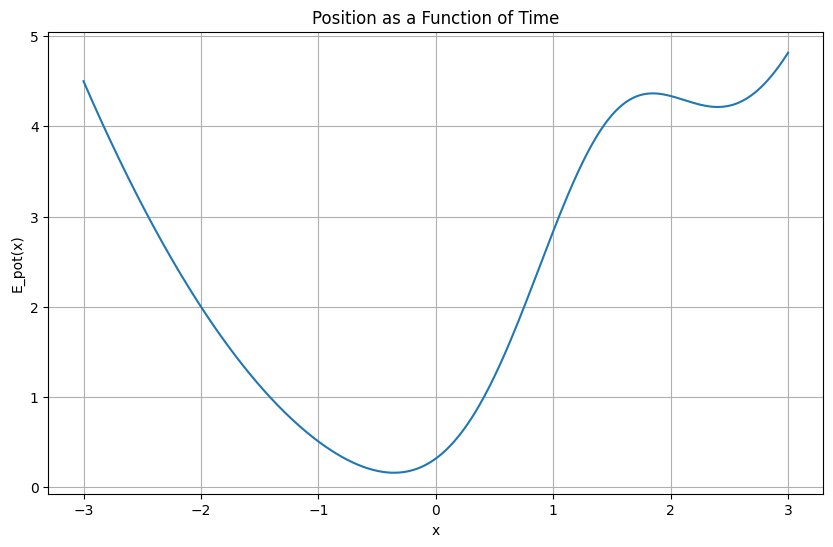

In [72]:
lamb = 1
x0 = 0
x1 = 1.5
A = 3
x = np.linspace(-3, 3, 400)

def E_pot(x):
    E = 0.5 * k * (x - x0)**2 + A * np.exp(-(x-x1)**2/(lamb**2))
    return E

y = E_pot(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('E_pot(x)')
plt.title('Position as a Function of Time')
plt.grid(True)
plt.show()


Exercise 26

Exercise 27

Exercise 28